**Домашнее задание №9 (вообще вроде 8)**

### Задание 1 (10 баллов).
- Это задание основано на [этой тетрадке](https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb)

- На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base).

- Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

-  Для обоих моделей качество должно быть >0.10 по f-мере (если у вас получаются нули, прогоните несколько экспериментов, изменяя параметры).

- Для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.

- Дополнительно для RuModernBERT сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.

## Imports

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from sklearn.metrics import f1_score

from transformers import AutoTokenizer, AutoModelForMaskedLM

## Data preparation

In [ ]:
! wget 'https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/transfer_learning_hg/lenta_sample.csv'

--2025-03-05 10:41:42--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628490 (1.6M) [text/plain]
Saving to: ‘lenta_sample.csv’

lenta_sample.csv    100%[===================>]   1.55M  --.-KB/s    in 0.05s   

2025-03-05 10:41:43 (31.3 MB/s) - ‘lenta_sample.csv’ saved [1628490/1628490]



In [ ]:
data = pd.read_csv('lenta_sample.csv')

In [ ]:
data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29


In [ ]:
data = data.drop(columns=['url', 'title', 'tags', 'date'])
data.rename(columns={'topic': 'label'}, inplace=True)
data.head()

,text,label
0,В Москве после серии массовых беспорядков на н...,Россия
1,Неизвестные вынесли из квартиры московского ст...,Россия
2,"В Ставропольском крае задержаны боевики, котор...",Россия
3,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия
4,Следственный комитет России возбудил уголовное...,Россия


In [ ]:
print(data['label'].unique())
print(len(data['label'].unique()))

['Россия' 'Мир' 'Экономика' 'Спорт' 'Наука и техника' 'Бывший СССР'
 'Культура' 'Интернет и СМИ' 'Из жизни' 'Дом' 'Силовые структуры'
 'Ценности' 'Бизнес' '69-я параллель' 'Крым' 'Легпром' 'Библиотека']
17


In [ ]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.label))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.label]

In [ ]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

## Definitions

In [ ]:
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))

        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()

            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [ ]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)

        return outputs

In [ ]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

## Model #1 modernbert-base

### With freezing

In [ ]:
model_id = "answerdotai/ModernBERT-base"
model_ModernBERT = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
# MAX_LEN for BERT is usually 512

training_set = Dataset(tokenizer, 512, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, 512, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
# freeezing

for param in model_ModernBERT.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_ModernBERT, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() \
                            if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(10)): # сколько эпох
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 4))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/10 [00:00<?, ?it/s]

0
Loss: 2.80319082736969; F1 measure: 0.09375
Loss: 2.987179934978485; F1 measure: 0.0859375
Loss: 2.8988707661628723; F1 measure: 0.109375
Loss: 2.899996280670166; F1 measure: 0.09765625
Loss: 2.8877697587013245; F1 measure: 0.103125
Loss: 2.8821955422560372; F1 measure: 0.09635416666666667
Loss: 2.865418629986899; F1 measure: 0.09375
Loss: 2.8825536146759987; F1 measure: 0.091796875
Loss: 2.889726936817169; F1 measure: 0.0954861111111111
Eval -  0.19166666666666665
1
Loss: 2.8557122945785522; F1 measure: 0.078125
Loss: 2.83214670419693; F1 measure: 0.078125
Loss: 2.8017462293306985; F1 measure: 0.09375
Loss: 2.7603458017110825; F1 measure: 0.09375
Loss: 2.7888941287994387; F1 measure: 0.09375
Loss: 2.8158515095710754; F1 measure: 0.09895833333333333
Loss: 2.8245596630232677; F1 measure: 0.10044642857142858
Loss: 2.8160343021154404; F1 measure: 0.115234375
Loss: 2.798957063092126; F1 measure: 0.11805555555555555
Eval -  0.16041666666666665
2
Loss: 2.6919586062431335; F1 measure: 0.218

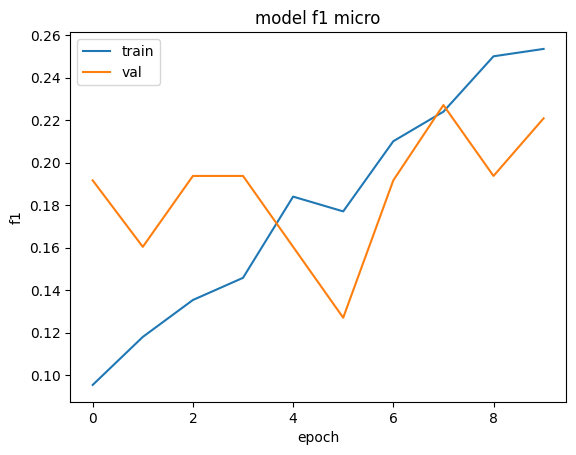

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.10      1.00      0.18         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.40      0.50      0.44         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       1.00      0.25      0.40         4
          10       1.00      0.67      0.80         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.25      1.00      0.40         1

    accuracy                           0.23        31
   macro avg       0.21      0.26      0.17        31
weighted avg       0.29      0.23      0.21        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Full model

In [ ]:
model_id = "answerdotai/ModernBERT-base"
model_ModernBERT = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# MAX_LEN for BERT is usually 512

training_set = Dataset(tokenizer, 512, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, 512, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_ModernBERT, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() \
                            if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(8)): # сколько эпох
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 4))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/8 [00:00<?, ?it/s]

0
Loss: 3.0469464659690857; F1 measure: 0.125
Loss: 3.036462366580963; F1 measure: 0.09375
Loss: 3.0462773640950522; F1 measure: 0.08333333333333333
Loss: 3.0204646438360214; F1 measure: 0.0703125
Loss: 2.9890321493148804; F1 measure: 0.08125
Loss: 2.9543626606464386; F1 measure: 0.08072916666666667
Loss: 2.9524692637579784; F1 measure: 0.08035714285714286
Loss: 2.932854250073433; F1 measure: 0.078125
Loss: 2.937556419107649; F1 measure: 0.0763888888888889
Eval -  0.09791666666666667
1
Loss: 2.8335652351379395; F1 measure: 0.125
Loss: 2.8558875024318695; F1 measure: 0.09375
Loss: 2.8305793603261313; F1 measure: 0.10416666666666667
Loss: 2.846908465027809; F1 measure: 0.0859375
Loss: 2.842799115180969; F1 measure: 0.075
Loss: 2.829655945301056; F1 measure: 0.08854166666666667
Loss: 2.826561118875231; F1 measure: 0.08035714285714286
Loss: 2.8262748420238495; F1 measure: 0.08203125
Loss: 2.8158728215429516; F1 measure: 0.08333333333333333
Eval -  0.03333333333333333
2
Loss: 2.674581944942

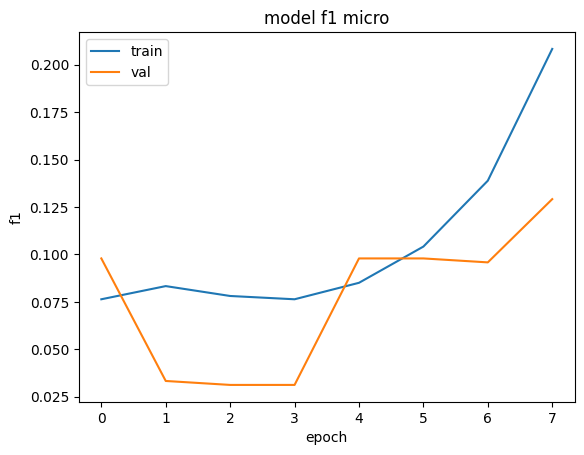

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# в начале прироста совсем нет, но потом начинает заметно появляться
# судя по примеру семинара, полная модель в целом мощнее замороженной

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.17      1.00      0.29         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.50      1.00      0.67         1

    accuracy                           0.13        31
   macro avg       0.05      0.15      0.07        31
weighted avg       0.03      0.13      0.05        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model #2 rumodernbert-base

### With freezing

In [ ]:
model_id = 'deepvk/RuModernBERT-base'
model_RuModernBERT = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

In [ ]:
# MAX_LEN for BERT is usually 512

training_set = Dataset(tokenizer, 512, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, 512, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
# freeezing

for param in model_RuModernBERT.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_RuModernBERT, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() \
                            if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(10)): # сколько эпох
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 4))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/10 [00:00<?, ?it/s]

0
Loss: 2.902377665042877; F1 measure: 0.0625
Loss: 2.8812321424484253; F1 measure: 0.03125
Loss: 2.87271656592687; F1 measure: 0.041666666666666664
Loss: 2.8620647490024567; F1 measure: 0.05078125
Loss: 2.8555187225341796; F1 measure: 0.046875
Loss: 2.852702170610428; F1 measure: 0.044270833333333336
Loss: 2.8378536786351884; F1 measure: 0.05357142857142857
Loss: 2.829386852681637; F1 measure: 0.056640625
Loss: 2.8241581320762634; F1 measure: 0.05555555555555555
Eval -  0.03125
1
Loss: 2.7502357959747314; F1 measure: 0.078125
Loss: 2.7710720598697662; F1 measure: 0.078125
Loss: 2.7712026238441467; F1 measure: 0.08333333333333333
Loss: 2.7723976522684097; F1 measure: 0.078125
Loss: 2.7749552726745605; F1 measure: 0.078125
Loss: 2.7631353735923767; F1 measure: 0.09114583333333333
Loss: 2.755846219403403; F1 measure: 0.08258928571428571
Loss: 2.7627638801932335; F1 measure: 0.080078125
Loss: 2.764138764805264; F1 measure: 0.08333333333333333
Eval -  0.03333333333333333
2
Loss: 2.69256418

In [ ]:
# в целом сразу видно, что модель слабее, но попробуем ещё эпох

for i in tqdm(range(10)): # сколько эпох
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 4))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/10 [00:00<?, ?it/s]

0
Loss: 2.6567195653915405; F1 measure: 0.171875
Loss: 2.6472014784812927; F1 measure: 0.171875
Loss: 2.668123404184977; F1 measure: 0.13541666666666666
Loss: 2.6902808994054794; F1 measure: 0.12890625
Loss: 2.6654473304748536; F1 measure: 0.13125
Loss: 2.684551179409027; F1 measure: 0.12760416666666666
Loss: 2.695135704108647; F1 measure: 0.12276785714285714
Loss: 2.699253737926483; F1 measure: 0.125
Loss: 2.71431385146247; F1 measure: 0.11805555555555555
Eval -  0.06451612903225806
1
Loss: 2.7177780866622925; F1 measure: 0.125
Loss: 2.6870438754558563; F1 measure: 0.140625
Loss: 2.699893534183502; F1 measure: 0.13020833333333334
Loss: 2.7281478941440582; F1 measure: 0.1171875
Loss: 2.7359466314315797; F1 measure: 0.1125
Loss: 2.746277024348577; F1 measure: 0.1171875
Loss: 2.7316027028220042; F1 measure: 0.10714285714285714
Loss: 2.72115471214056; F1 measure: 0.109375
Loss: 2.7237048082881503; F1 measure: 0.10590277777777778
Eval -  0.16129032258064516
2
Loss: 2.6985737681388855; F1 m

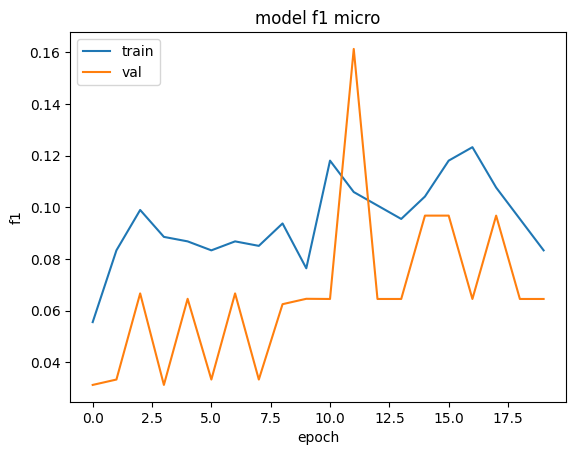

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# всего было 18 эпох, единственный результат f1 > 0.1 был на 11-ой эпохе

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.07      1.00      0.13         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.06      1.00      0.11         1

    accuracy                           0.06        31
   macro avg       0.01      0.15      0.02        31
weighted avg       0.00      0.06      0.01        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Full model

In [ ]:
model_id = 'deepvk/RuModernBERT-base'
model_RuModernBERT = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# MAX_LEN for BERT is usually 512

training_set = Dataset(tokenizer, 512, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, 512, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_RuModernBERT, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() \
                            if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(10)): # сколько эпох
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 4))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/10 [00:00<?, ?it/s]

0
Loss: 4.103463590145111; F1 measure: 0.0625
Loss: 3.9299992322921753; F1 measure: 0.0703125
Loss: 3.695916692415873; F1 measure: 0.06770833333333333
Loss: 3.532089799642563; F1 measure: 0.078125
Loss: 3.396612024307251; F1 measure: 0.0875
Loss: 3.313253531853358; F1 measure: 0.09114583333333333
Loss: 3.2943077428000316; F1 measure: 0.08258928571428571
Loss: 3.258816733956337; F1 measure: 0.080078125
Loss: 3.218495739830865; F1 measure: 0.078125
Eval -  0.06458333333333333
1
Loss: 2.8643688559532166; F1 measure: 0.09375
Loss: 2.8134465515613556; F1 measure: 0.09375
Loss: 2.804071386655172; F1 measure: 0.109375
Loss: 2.7987513095140457; F1 measure: 0.109375
Loss: 2.794939196109772; F1 measure: 0.103125
Loss: 2.7638787428538003; F1 measure: 0.11197916666666667
Loss: 2.7641433903149197; F1 measure: 0.12276785714285714
Loss: 2.7537283822894096; F1 measure: 0.1171875
Loss: 2.7733034756448536; F1 measure: 0.1111111111111111
Eval -  0.1
2
Loss: 2.7176676988601685; F1 measure: 0.125
Loss: 2.6

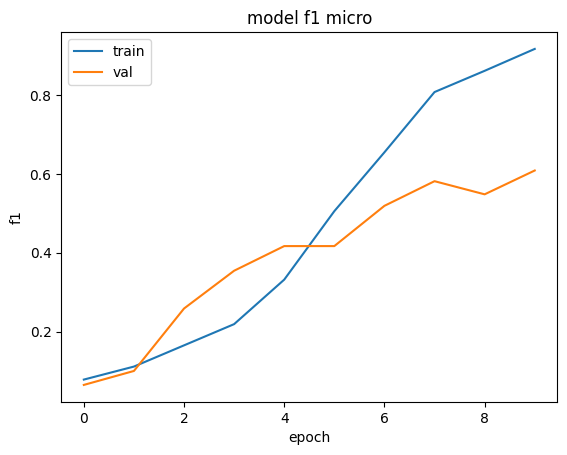

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       0.25      1.00      0.40         2
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89         4
           6       1.00      0.80      0.89         5
           8       1.00      0.67      0.80         3
           9       1.00      0.25      0.40         4
          10       0.50      1.00      0.67         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          15       1.00      0.33      0.50         3
          16       0.00      0.00      0.00         1

    accuracy                           0.61        31
   macro avg       0.54      0.50      0.47        31
weighted avg       0.72      0.61      0.59        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

## Comparison

Ниже скопированы результаты

NB: параметры обучения моделей не всегда совпадают, но отличаются несильно см. обучение выше.

Ещё ниже -- обобщение

In [ ]:
print(classification_report(valid_targets, preds))

# ModernBERT freezed
# фактически не-нулевое качество только у пяти классов

              precision    recall  f1-score   support

           0       0.10      1.00      0.18         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.40      0.50      0.44         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       1.00      0.25      0.40         4
          10       1.00      0.67      0.80         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.25      1.00      0.40         1

    accuracy                           0.23        31
   macro avg       0.21      0.26      0.17        31
weighted avg       0.29      0.23      0.21        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(valid_targets, preds))

# ModernBERT full
# очень слабое качество, хоть как-то определяет только два класса

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.17      1.00      0.29         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.50      1.00      0.67         1

    accuracy                           0.13        31
   macro avg       0.05      0.15      0.07        31
weighted avg       0.03      0.13      0.05        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(valid_targets, preds))

# RussianModernBERT freezed
# совсем плохое качество, едва определяет два класса
# (но см. выше, что на 11-ой эпохе качество
# переходило за порог в 0.1 по f1-мере -- вообще надо
# было бы смотреть на её результаты, но раз уж всё равно
# слабые, не буду запускать именно 11 эпох и смотреть)

              precision    recall  f1-score   support

           0       0.07      1.00      0.13         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.06      1.00      0.11         1

    accuracy                           0.06        31
   macro avg       0.01      0.15      0.02        31
weighted avg       0.00      0.06      0.01        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(valid_targets, preds))

# RussianModernBERT full
# несмотря на совсем короткое обучение, очень неплохие
# (особенно в сравнении с другими моделями) метрики
# имеет нулевое качество у пяти классов из шестнадцати
# у многих есть очень приличные f1 > 0.8

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       0.25      1.00      0.40         2
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89         4
           6       1.00      0.80      0.89         5
           8       1.00      0.67      0.80         3
           9       1.00      0.25      0.40         4
          10       0.50      1.00      0.67         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          15       1.00      0.33      0.50         3
          16       0.00      0.00      0.00         1

    accuracy                           0.61        31
   macro avg       0.54      0.50      0.47        31
weighted avg       0.72      0.61      0.59        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Главный вывод -- на этом датасете с большим отрывом побеждает RuModernBERT без заморозки. Другие модели научились предсказывать только два или пять классов (против 11 у него). Интересно заметить, что, например, самая первая модель научилась неплохо (f1=0.4) определять 16-ый класс, тогда как этот RuModernBERT не научился совсем. Понятно, что я обучал специально мало, чтобы не ждать очень долго, так что тренд при достаточном обучении может быть другим (оптимистическое предположение: все модели станут более-менее приемлемыми, а полный RuModernBERT научится отличать все классы)

Усредненный вектор по всем hidden_state не проверял